# 🤦Batching Pitfall

## ⚙️ 1. Initial Implementation

In [3]:
# DELETE THIS CELL BEFORE SUBMISSION
import sys
import importlib
sys.path.append('/content/drive/MyDrive/Capstone/final')
import run_dbscan
importlib.reload(run_dbscan)

<module 'run_dbscan' from '/content/drive/MyDrive/Capstone/final/run_dbscan.py'>

In [10]:
import run_dbscan
import pandas as pd

# Load DataSet
synthetic_ts_df = pd.read_csv('generated_dataset.csv')

# Run DBSCAN to get clusters
clusters = run_dbscan.fit(synthetic_ts_df['value'].values.reshape(-1,1))

DBSCAN Params | EPS: 0.5, min_sample: 4
* Cluster Count: 52
* Noise Points: 7


### 📈 Visualization

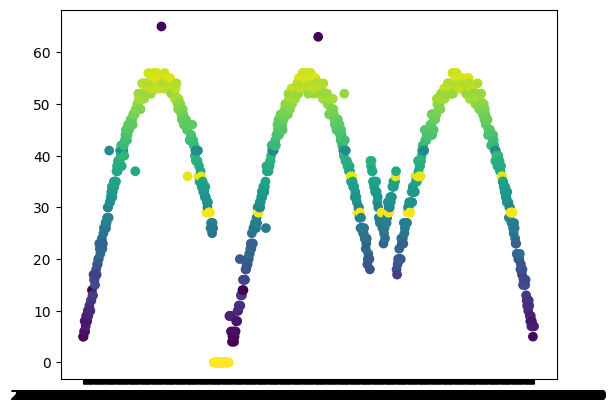

In [11]:
import matplotlib.pyplot as plt

plt.scatter(synthetic_ts_df['timestamp'], synthetic_ts_df['value'], c=clusters['clusters'], cmap='viridis')

### 💭 Evaluation and Realization

The cluster visualization demonstrated significant multi-modal distribution rather than the anticipated unimodal structure. Consequently, the hypothesis that the dataset would consist of one dense central mass with sparse outliers was invalidated by the high degree of fragmentation observed.

## ⚖️ 2. Implementation with Data Scaling

### 📈 Visualization

DBSCAN Params | EPS: 0.1, min_sample: 4
* Cluster Count: 2
* Noise Points: 2


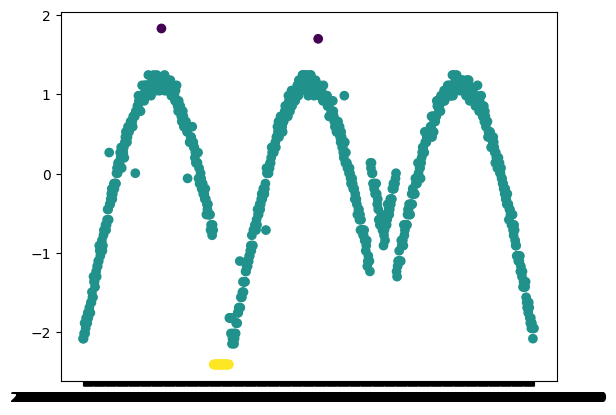

In [17]:
import run_dbscan
from sklearn.preprocessing import StandardScaler

# Load DataSet
synthetic_ts_df = pd.read_csv('generated_dataset.csv')

# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(synthetic_ts_df['value'].values.reshape(-1, 1))

# Reshape the 'Value' column to be 2-dimensional as DBSCAN expects
clusters = run_dbscan.fit(
    X_scaled,
    eps=0.1,
    min_samples=4
)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

plt.scatter(synthetic_ts_df['timestamp'], X_scaled, c=clusters['clusters'], cmap='viridis')

### 💭 Evaluation and Realization

Despite the application of feature scaling to ensure uniform variance, the visualization revealed a highly fragmented landscape with an extensive number of clusters. This result directly contradicts the initial hypothesis of a singular, dominant cluster with sparse anomalies, suggesting instead a highly heterogeneous dataset with multiple distinct sub-populations.

## ⏲ 3. Implemenation with Time Series Lag

### 📈 Visualization

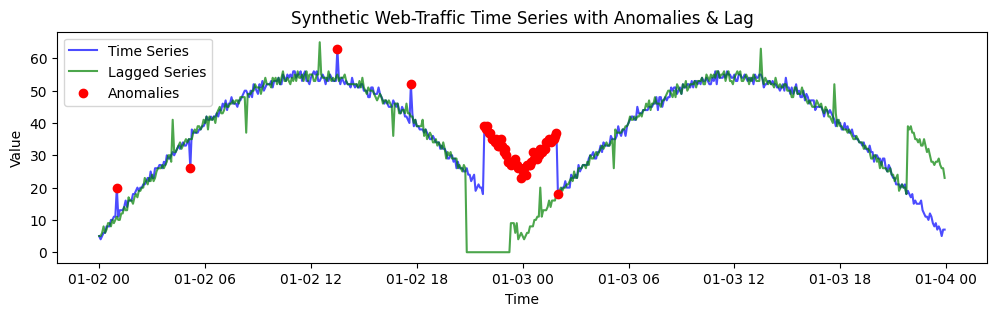

DBSCAN Params | EPS: 1, min_sample: 4
* Cluster Count: 15
* Noise Points: 77


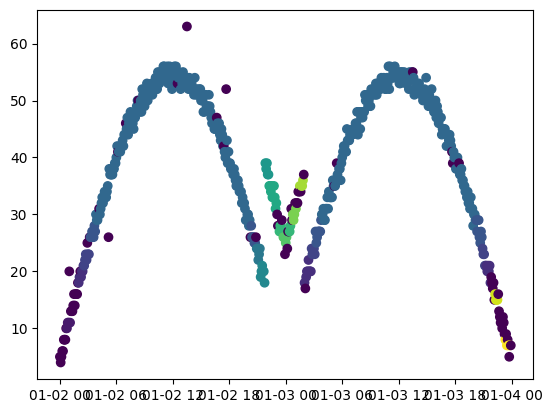

In [32]:
import run_dbscan
import matplotlib.pyplot as plt
import pandas as pd

# Load DataSet
synthetic_ts_df = pd.read_csv('generated_dataset.csv')

# Convert 'timestamp' column to datetime objects before setting as index
synthetic_ts_df['timestamp'] = pd.to_datetime(synthetic_ts_df['timestamp'])

# Create a new Dataframe with a new column to represent the value of the previous day
lagged_synthetic_ts_df = synthetic_ts_df.set_index('timestamp')
lagged_synthetic_ts_df['Value_Lag1D'] = lagged_synthetic_ts_df['value'].shift(periods=1, freq='D')

# Drop missing values
lagged_synthetic_ts_df = lagged_synthetic_ts_df.dropna()

# Plot the existing time series data
plt.figure(figsize=(12, 3))
plt.plot(lagged_synthetic_ts_df.index, lagged_synthetic_ts_df['value'], label='Time Series', color='blue', alpha=0.7)

# Plot the lagging series data
plt.plot(lagged_synthetic_ts_df.index, lagged_synthetic_ts_df['Value_Lag1D'], label='Lagged Series', color='green', alpha=0.7)

# Plot the Anomaly Points
plt.scatter(lagged_synthetic_ts_df[lagged_synthetic_ts_df['is_anomaly'] == 1].index,
            lagged_synthetic_ts_df[lagged_synthetic_ts_df['is_anomaly'] == 1]['value'],
            color='red', label='Anomalies', zorder=5)

# Set other plot details
plt.title("Synthetic Web-Traffic Time Series with Anomalies & Lag")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# Determine the clusters
clusters = run_dbscan.fit(
    data=lagged_synthetic_ts_df[['value','Value_Lag1D']].values,
    eps=1,
    min_samples=4
)['clusters']

# Plot the clustering
plt.scatter(lagged_synthetic_ts_df.index, lagged_synthetic_ts_df['value'], c=clusters)

### 💭 Evaluation and Realization

Even with time-series lagging applied to better define the 'normal' operating window, the data remains highly segmented into numerous distinct clusters. This result disproves our assumption that the dataset would consist of one cohesive group and a few outliers. Instead, it appears the data is composed of various sub-behaviors, each forming its own legitimate cluster.

## 📍Final Evaluation and Hypothesis Adjustment

Refining our preprocessing and model parameters revealed a vital requirement: **temporal alignment**.

* Because RRCF captures anomalies within a streaming window, DBSCAN is currently at a disadvantage by attempting to cluster the entire static history.

* **It is best to transition to a windowed, stream-based DBSCAN** to capture shifting densities and ensure consistent comparison between the two algorithms.